https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a

In [1]:
import sys
import os

import chart_studio.plotly as plty
import plotly.graph_objs as gobjs

import plotly

sys.path.insert(0, os.path.abspath('../py'))
from Secrets import ReadSecrets


account = ReadSecrets()\
        .set_secrets_path('../secrets.json')\
        .set_default_accessors()\
        .access('plotly')['main_account']

plty.sign_in(account['username'], account['apiKey'])


from datetime import datetime as calendar
import numpy as np

from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
yf.pdr_override()

from DataHelper import DataHelper

from plotly import tools

/home/andre/Desktop/pythonTradingAlgos/tradingalgos/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from pandas import datetime as pd_datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/home/andre/Desktop/pythonTradingAlgos/tradingalgos/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

In [4]:
data, close, extractors = DataHelper.get_history_formatted(['AAPL', 'MSFT', '^GSPC', 'VALE3.SA'], calendar(2018, 1 ,3), calendar(2020, 2, 1))
msft = extractors['MSFT']()
vale3 = extractors['VALE3.SA']()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'VALE3 Autocorrelation plot')

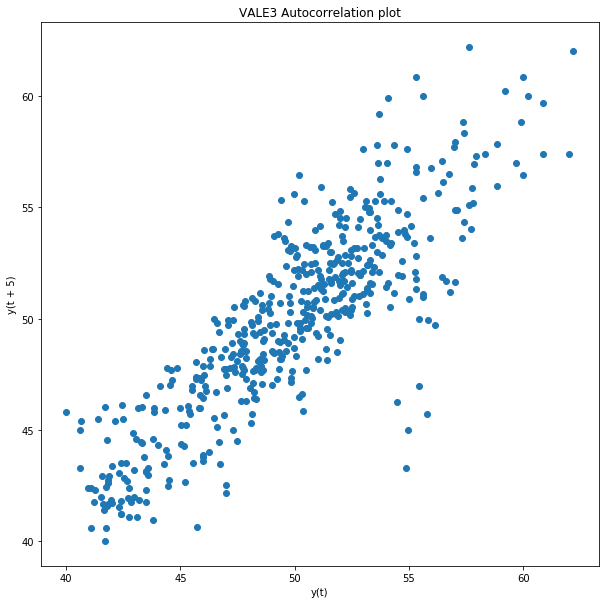

In [5]:
plt.figure(figsize=(10,10))
lag_plot(vale3.Open, lag=5)
plt.title('VALE3 Autocorrelation plot')

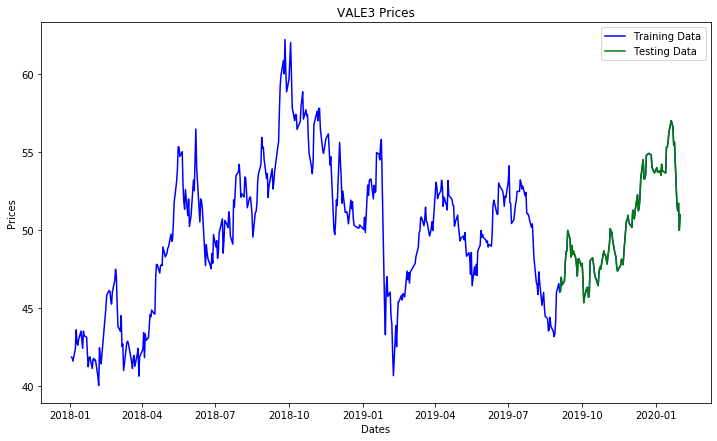

In [6]:
train_data, test_data = vale3[0:int(len(vale3)*0.8)], vale3[int(len(vale3)*0.8):]
plt.figure(figsize=(12,7))
plt.title('VALE3 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(vale3.Open, 'blue', label='Training Data')

plt.plot(test_data.Open, 'green', label='Testing Data')


plt.legend()

In [14]:
def smape_kun(y_true, y_pred):
    return np.mean(
        (
            np.abs(np.array(y_pred) - np.array(y_true)) * 200 / ( np.abs(y_pred) + np.abs(y_true) )
        )
    )

In [8]:
train_ar = train_data['Open'].values
test_ar = test_data['Open'].valueshistory = [x for x in train_ar]


In [9]:
history = [x for x in train_ar]
print(type(history))

<class 'list'>


In [12]:
predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    
    if t % 10 == 0:
        print(f'{((t+1 / len(test_ar))*100):.2f}%', end=" | ")

0.00%
2.44%
4.88%
7.32%
9.76%
12.20%
14.63%
17.07%
19.51%
21.95%
24.39%
26.83%
29.27%
31.71%
34.15%
36.59%
39.02%
41.46%
43.90%
46.34%
48.78%
51.22%
53.66%
56.10%
58.54%
60.98%
63.41%
65.85%
68.29%
70.73%
73.17%
75.61%
78.05%
80.49%
82.93%
85.37%
87.80%
90.24%
92.68%
95.12%
97.56%


In [15]:
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 2.032
Symmetric mean absolute percentage error: 10.626


In [55]:
predictions_df = pd.DataFrame(index = test_data.index, data={'value': list(map(lambda el: el[0], predictions))})
predictions_df

ValueError: Shape of passed values is (410, 1), indices imply (103, 1)

In [54]:
trace_price = gobjs.Scatter(
                x=vale3.index,
                y=vale3.Open,
                line = dict(color = '#17BECF'),
                name='Training Data',
                opacity = 1)

trace_predictions = gobjs.Scatter(
                x=test_data.index,
                y=predictions.value,
                line = dict(color = 'red'),
                name='Predicted Price',
                opacity = 1,
                mode="markers",
                marker = dict(size = 10, color = 'red', symbol = 'circle', line=dict(width=2, color='DarkSlateGrey')
                ))

trace_actual_price = gobjs.Scatter(
                x=test_data.index,
                y=test_data.Open,
                line = dict(color = '#20FAAA'),
                name='Actual Price',
                opacity = 1)

plty.iplot([trace_price, trace_actual_price, trace_predictions], filename='arima')

ValueError: x and y must have same first dimension, but have shapes (103,) and (410, 1)

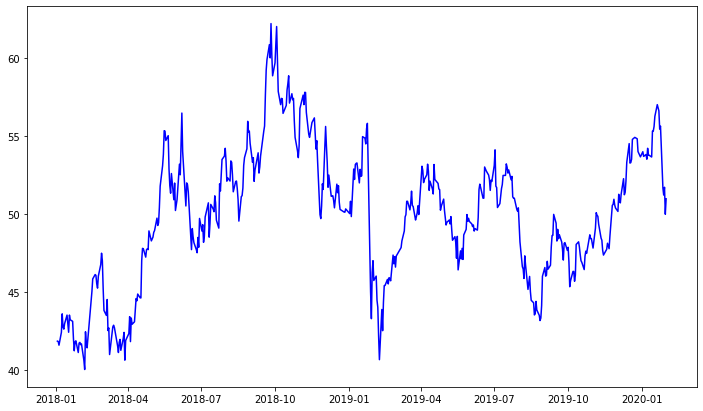

In [17]:
plt.figure(figsize=(12,7))
plt.plot(vale3.Open, 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('VALE3 Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()